<!--- *by "Flo Guida" aka [Scott H. Hawley](https://bsky.app/profile/drscotthawley.bsky.social), Oct/Nov. 2025* -->

<a href="https://colab.research.google.com/github/drscotthawley/DLAIE/blob/main/2025/Guidance_for_Flows.ipynb" target="_"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Abstract

This tutorial demonstrates how to add inference-time controls to pretrained flow-based generative models to make them perform tasks they weren't trained to do. We take an unconditional flow model trained on MNIST digits and apply two types of guidance: classifier guidance to generate specific digits, and inpainting to fill in missing pixels. Both approaches work by adding velocity corrections during the sampling process to steer the model toward desired outcomes. Since modern generative models operate in compressed latent spaces, we examine guidance methods that work directly in latent space as well as those that decode to pixel space. We also explore PnP-Flow, which satisfies constraints by iteratively projecting samples backward and forward in time rather than correcting flow velocities. The approaches demonstrated here work with other flow models and control tasks, so you can guide flows where you want them to go.



# Introduction

In this tutorial, we'll explore inference-time "plugin" methods for flow matching and rectified flow generative models like FLUX or Stable Audio Open Small. Unlike classifier-free guidance (CFG), which requires training the model with your desired conditioning signal, these plugin guidance methods let you add controls at inference time—even for conditions the model never saw during training.

This tutorial assumes familiarity with flow-based generative models.  See the blog post ["Flow With What You Know"](https://drscotthawley.github.io/blog/posts/FlowModels.html) [@hawley2025flowwithwhat] for an overview.
The key insight is that flow models generate samples through iterative integration, and at each step we can add small velocity corrections to steer toward specific goals. This works for various objectives: generating specific classes, filling in missing regions, or satisfying other desired constraints.

Our discussion will bring us up to date on guidance methods for latents-space rectified flow models.  While there's an extensive literature on guidance for diffusion models -- see Sander Dielemann's excellent blog post [@dieleman2022guidance] for an overview --- flow matching allows us to cast these in a more accessible and intuitive way.
The paradigm of latent generative models is covered in another superb Dieleman post [@dieleman2025latents], and
 combining latent-space models with flow-based guidance gives us powerful, flexible tools for adding flexible controls to efficient generation.








Let's review the picture for flow-based generative modeling in latent space... **TODO:** say more


## The Latent Flow-Matching Setup

Before exploring guidance, let's review how latent flow models work.  The following diagram illustrates three key concepts: 


**a)** A VAE compresses pixel-space images into compact latent representations. 

<style>
img {
    display: block;
    margin: 0 auto;
    transition: transform 0.4s ease;
    position: relative;
    z-index: 0;
}
img:hover {
    -webkit-transform: scale(1.3);
    transform: scale(1.3);
    z-index: 1;
}

.cell-output-display {
    overflow: visible !important;
}
.cell-output {
    overflow: visible !important;
}
</style>

![](images/vae_flow_diag-VAE.svg)


**b)** The flow model operates in this latent space, transforming noise (source, t=0) into structured data (target, t=1) through iterative integration. The decoder then converts the final latents back to pixels.

![](images/vae_flow_diag-Generation.drawio.svg)

**c)** While general flows can follow curved trajectories, some of our methods will focus on straight-line flows (rectified flows/optimal transport) which offer simpler, more intuitive paths—making guidance particularly elegant.

![](images/vae_flow_diag-FlowTypes.drawio.svg)


**TODO:** add more review text...

# Projecting and Correcting
Intuitively, guidance amounts to "steering" during the integration of the flow model in order to end up at a desired end point.  The [following video](https://bsky.app/profile/drscotthawley.bsky.social/post/3m3df2idqrc2g) provides a useful metaphor:  

In [ ]:
#| echo: false
from IPython.display import HTML
HTML('''
<div style="display: flex; justify-content: center;">
<blockquote class="bluesky-embed" data-bluesky-uri="at://did:plc:sw457c7pedt3n57ci6qlrws6/app.bsky.feed.post/3m3df2idqrc2g" data-bluesky-cid="bafyreig53ufqtdsyf6np5xhoc75wdbd7pwlgxwbqeg4gatq5atvigdk54e" data-bluesky-embed-color-mode="system"><p lang="en">Been working on a tutorial on Guidance for (latent) flow-based generative models, and happened upon a great metaphor today while taking a little &quot;me&quot; time. :-)<br><br><a href="https://bsky.app/profile/did:plc:sw457c7pedt3n57ci6qlrws6/post/3m3df2idqrc2g?ref_src=embed">[image or embed]</a></p>&mdash; Scott H. Hawley (<a href="https://bsky.app/profile/did:plc:sw457c7pedt3n57ci6qlrws6?ref_src=embed">@drscotthawley.bsky.social</a>) <a href="https://bsky.app/profile/did:plc:sw457c7pedt3n57ci6qlrws6/post/3m3df2idqrc2g?ref_src=embed">Oct 16, 2025 at 1:26 PM</a></blockquote><script async src="https://embed.bsky.app/static/embed.js" charset="utf-8"></script>
</div>
''')

Ok, the analogy's not quite right: you can't just steer, you are going to have to paddle a little bit.  In other words, you're going to have to provide a bit of a *extra velocity* to correct the where the "current" flow is taking you.

In flow matching, we go from a source data (distribution) at time $t=0$ to target
data at $t=1$.  Since this tutorial applies to latent space, we'll use the letter $z$ for position, such as $z_t$ being the position at time $t$.

When you're "looking ahead" to estimate where you'll end up, you project linearly along the current velocity $\vec{v_t}$ for a duration of the remaining time. Let's call this estimate $\widehat{z_1}$, your projected endpoint :

$$ \widehat{z_1} = z_t + (1-t)\vec{v_t} \tag{1} $$

...but perhaps that's not where you want to go. Where you want to go is a distance $\Delta \widehat{z_1}$ from $\widehat{z_1}$, and to get there you'll have to make a"course correction" $\Delta \hat{v}$, as shown in the following diagram:  

![](images/guidance_vectors.png){.img1}


By similar triangles, $\Delta \widehat{z_1} = (1-t)\Delta \vec{v}$, which means the course correction you want is

$$ \Delta \vec{v} = { \Delta \widehat{z_1} \over 1-t } \tag{2} $$


::: {.callout-note}
### Mathematical Details

Since you're going to see more math once you try to read the scholarly literature on these topics, let's go a bit further into the math...

So $\Delta \widehat{z_1}$ is a measure of the *deviation* from the desired endpoint. Now, in practical application we won't actually use the "distance" $\Delta \widehat{z_1}$, but we'll use something that functions *like* a distance, such as a K-L divergence or Mean Squared Error (MSE).

When doing inference, this deviation serves as a "loss" when training models something we minimize via gradient descent, except we'll vary the flow positions $z$ instead of the model weights.  More specifically, we'll consider the "likelihood"
 $p( \widehat{z_1} | y )$ of getting a $z_1$ that matches a given control $y$, and we'll seek to maximize that likelihood, or equivalently to *minimize the negative* log-likelihood.

 The expression $-\nabla_{\widehat{z_1}} \log p( \widehat{z_1} | y )$ essentially answers the question, "in which direction should I adjust $\widehat{z_1}$ so as to make
  $p( \widehat{z_1} | y )$ more likely? This gives us a direction and a magnitude, which we then multiply by a ~~learning rate~~ "guidance
  strength" $\eta$ to turn it into a step size.
:::


Applying this gradient-based approach, our expression for $\Delta v$ will involve replacing $\Delta \widehat{z_1}$ in (2) with
  $- \eta \nabla_{\widehat{z_1}} \log p( \widehat{z_1} | y$:

$$ \Delta \vec{v} =  - \eta {1 \over 1-t } \nabla_{z_t} \log p( \widehat{z_1} | y ) \tag{3} $$

where we used the fact that $\nabla_{\widehat{z_1}} = \nabla_{z_t}$ (since $\widehat{z_1} \propto z_t$). The factor of $1/(1-t)$ means small corrections suffice early on, but later times require larger adjustments—though other time scalings are possible, as we'll see.

Now let's apply this to a concrete example.

# Classifier Guidance

If we want our model to generate a member of a particular class, we can use an external classifier to examine the generated samples. The constraint to minimize will be the difference between the desired class and the `argmax` of the classifier output (or some similar relationship that enforces the class compliance).

For our flow model, let's use [Marco Cassar's winning submission](https://github.com/Ocrabit/dl_class_projects/blob/main/dl_experimentation/submissions/marco_submission.py) from the [2025 DLAIE Leaderboard Contest](https://2025-dlaie-leaderboard.streamlit.app/) on unconditional latent flow matching of MNIST digits.  For the classifier, we'll use the [official evaluation classifier](https://github.com/DLAIE/2025-LeaderboardContest/blob/main/evaluate_submission.py) from the same contest.

## Setup the Flow Model and Classifier

In [ ]:
#| include: false

# Get some dependencies
import os
os.environ['PATH'] = f"/app/data/.local/bin:{os.environ['PATH']}"

# CPU-only PyTorch on solveit. For GPU support, remove "--index-url <url>"
!pip install -q torch==2.8.0 torchvision==0.23.0 --index-url https://download.pytorch.org/whl/cpu
!pip install -qU safetensors gdown wandb ipywidgets

In [ ]:
#| include: false

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")
import os
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm


# Set some info about what platform we're running on.
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print("device =",device)

platform = 'local'
dir_prefix = './'

device = mps


In [ ]:
#| include: false

# Get Marco's VAE and Flow model(s)
!wget -q --no-clobber=off https://raw.githubusercontent.com/Ocrabit/dl_class_projects/refs/heads/main/dl_experimentation/submissions/marco_submission.py

from marco_submission import SubmissionInterface, integrate_path, rk4_step

sub = SubmissionInterface().to(device)   # Get Marco's VAE and Flow model.

Downloading...
From: https://drive.google.com/uc?id=1rP6yP5yixCI1M7LOrv9v9vJkeYkXnptG
To: /Users/shawley/github/blog/posts/downloaded_vae.safetensors
100%|██████████████████████████████████████████████████████████████████████████████████| 660k/660k [00:00<00:00, 5.43MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pAU4p6xQMDgAuywu-go-5iM4qPDXgJFc
To: /Users/shawley/github/blog/posts/downloaded_flow.safetensors
100%|████████████████████████████████████████████████████████████████████████████████| 42.6k/42.6k [00:00<00:00, 1.75MB/s]


  0%|          | 0.00/660k [00:00<?, ?B/s]

100%|██████████| 660k/660k [00:00<00:00, 6.83MB/s]

Downloading...
From: https://drive.google.com/uc?id=1pAU4p6xQMDgAuywu-go-5iM4qPDXgJFc
To: /Users/shawley/github/blog/posts/downloaded_flow.safetensors


  0%|          | 0.00/42.6k [00:00<?, ?B/s]

100%|██████████| 42.6k/42.6k [00:00<00:00, 1.88MB/s]

Let's generate and draw some sample images.

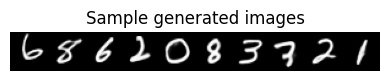

In [ ]:
#| code-fold: true

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# generate some samples
n_samples = 10
x1 = sub.generate_samples(n_samples=n_samples)
x1.shape


def show_grid(x1, title=None):
    if len(x1.shape) == 3: x1 = x1.unsqueeze(1)  # add channels dim
    grid = make_grid(x1, nrow=10, padding=2, normalize=False)
    plt.figure(figsize=(4, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu(), cmap='gray')
    plt.axis('off')
    if title: plt.title(title)
    plt.tight_layout()
    plt.show()

show_grid(x1, "Sample generated images")

Now let's setup the (pretrained) classifier we'll use for the guidance:

In [ ]:
#| include: false

# Get the evaluation classifier
!wget -q --no-clobber=off https://raw.githubusercontent.com/DLAIE/2025-LeaderboardContest/refs/heads/main/evaluate_submission.py

from evaluate_submission import setup_resnet

classifier = setup_resnet().to(device).eval()

#@torch.no_grad()  <--- Don't do this here! We'll use classifier gradients for guidance later
def classify(classifier, x, use_argmax=False):
    if len(x.shape) == 3: x = x.unsqueeze(1)  # add channels dim
    logits = classifier(x)
    probs = F.softmax(logits, dim=1)
    return torch.argmax(probs, dim=1) if use_argmax else (logits, probs)

# test that
with torch.no_grad():
    logits, probs = classify(classifier, x1)
    print(logits.shape, probs.shape)
    pred_class = classify(classifier, x1, use_argmax=True)
    print(pred_class.cpu())

torch.Size([10, 10]) torch.Size([10, 10])
tensor([6, 8, 6, 2, 0, 8, 3, 3, 2, 1])


Let's make a plot showing the classifier's output probabilities (aka likelihoods) across all classes, for all 10 samples. The samples will be the rows, and the class-likelihoods outputs from the classifier will be the columns, where brightness is correlated with likelihood.

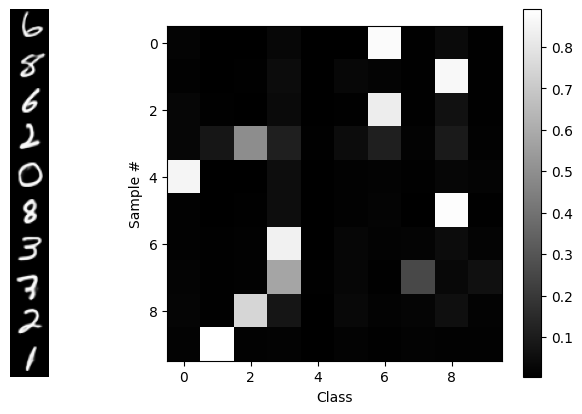

In [ ]:
#| code-fold: true

def show_probs(probs, x=None):
    """show probs as colormap intensities via imshow.
    have each row be a sample and each column be a class probability"""
    ncols = 1 if x is None else 2
    fig, axs = plt.subplots(1, ncols, figsize=(8, 4))
    if ncols == 1: axs = [axs]

    if x is not None:  # show a little version of the x image for each row
        axs[0].imshow(make_grid(x.unsqueeze(1).cpu(), nrow=1, padding=2, normalize=False).permute(1, 2, 0).cpu(), cmap='gray')
        axs[0].axis('off')

    # show probabilities as an intensity map
    im = axs[ncols-1].imshow(probs.cpu(), cmap='gray')
    axs[ncols-1].set_xlabel("Class")
    axs[ncols-1].set_ylabel("Sample #")
    plt.colorbar(im, ax=axs[ncols-1])
    plt.tight_layout()

show_probs(probs, x=x1)

...So we see that this is an *unconditional* generative model: there's nothing determining the classes of the outputs -- until we add guidance, below! ;-)   In a short while, we'll reproduce that diagram, but we'll use guidance to get one class per sample, in order, along the diagonal.

In what follows, we'll try to use classifier guidance to make that the probabilities in the above grid image follow a diagonal, i.e., one image for each class in succession.

To do that, we're going to have to "break open" the `generate_samples` routine and even the `integrate_path` routine to allow us to *add a correction* to the velocity $v_t$ generated by the flow model at time $t$.  That correction $\Delta v$  will be based on the classifier's output using the *projected estimate* $\widehat{x_1}$ of the final data, which we'll obtain via *linear extrapolation*.  

In our latent space model, we flow with latents $z$ which must be *decoded* using the VAE's decoder $\mathscr{D}$ :

$$ \widehat{z_1} = z_t + (1-t) v_t $$
$$ \widehat{x_1} = \mathscr{D}(\widehat{z_1}) $$

The correction $\Delta v$  will generated from a constraint which in this case is just like regular "classifier loss" function in a supervised learning problem. The desired class label is the "target" and the classifier output of the projected estimate is the "prediction".


Our code will follow this general layout:  

```python
loss_fn = torch.nn.CrossEntropyLoss()

v_t = flow_model(z_t, t)
z1_hat = z_t + (1-t)*v_t               # projected destination
x1_hat = sub.vae.decoder(z1_hat)       # decode it to pixel space
probs = classify(classifier, x1_hat)   # classifer operates in pixel space
loss = loss_fn(probs, target)          # "supervised learning"
delta_v = magic_function(loss,...???)  # <--- here's the part we need to work out
v_t = v_t + delta_v * guidance_strength  # we can set the strength of the correction
```

So what magic function will turn that `loss` into a *velocity*? Well, we can turn to good old Gradient Descent!  Except instead of taking the gradient with respect to the model weights like we used to, we're going to take the gradient with respect to the flow coordinates $z$  in the latent space, thereby generating a vector in the latent space.

The insight is that PyTorch lets us compute the gradient with respect to anything. We just need to tell it what we want. And we need to be careful to make sure that the VAE and flow models stay frozen, so the only thing that's allowed to change are the latents $z$.

The cleanest way to pull this off, code-wise, is to create a function called `compute_v()` which for starters will just call the flow model, but then we'll add to it with guidance info:

In [ ]:
# wherever we used to just call flow_model(), we'll now call compute_v() instead
@torch.no_grad()
def compute_v(flow_model, z, t, guidance_dict=None, **kwargs):
    v_t = flow_model(z, t)
    if guidance_dict is not None:
        v_t += compute_dv(v_t, z, t, guidance_dict, **kwargs)
    return v_t

@torch.enable_grad()  # <-- later, this will be a key for getting guidance
def compute_dv(v_t, z, t, g:dict, **kwargs):
    "placeholder for now, will add guidance math later"
    return torch.zeros_like(v_t).detach() # no correction yet; no gradients returned

We'll to use our usual "boilerplate" flow integration code, except we'll add "`**kwargs`" everywhere so we can pass controls "all the way in" to the `compute_dv()` guidance routine, and pair `flow_model()` as an arg to `compute_v()` via `functools.partial`.

In [ ]:
#| code-fold: true

# flow integration routines, slightly modified from "flow with what you know" blog

from functools import partial  # use partial to package flow_model with compute_v

@torch.no_grad()
def rk4_step(f, y, t, dt, **kwargs):  # regular rk4, + kwargs passthrough
    # f: callable (y, t) -> dy/dt
    k1 = f(y, t, **kwargs)
    k2 = f(y + 0.5 * dt * k1, t + 0.5 * dt, **kwargs)
    k3 = f(y + 0.5 * dt * k2, t + 0.5 * dt, **kwargs)
    k4 = f(y + dt * k3, t + dt, **kwargs)
    return y + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

@torch.no_grad()
def warp_time(t, dt=None, s=.5):
    """Parametric Time Warping: s = slope in the middle.
        s=1 is linear time, s < 1 goes slower near the middle, s>1 goes slower near the ends
        s = 1.5 gets very close to the "cosine schedule", i.e. (1-cos(pi*t))/2, i.e. sin^2(pi/2*x)"""
    if s < 0 or s > 1.5: raise ValueError(f"s={s} is out of bounds.")
    tw = 4 * (1 - s) * t ** 3 + 6 * (s - 1) * t ** 2 + (3 - 2 * s) * t
    if dt:  # warped time-step requested; use derivative
        return tw, dt * 12 * (1 - s) * t ** 2 + 12 * (s - 1) * t + (3 - 2 * s)
    return tw


@torch.no_grad()
def integrate_path(model, initial_points, step_fn=rk4_step, n_steps=100, warp_fn=None, latent_2d=False, prog_bar=True, t0=0, **kwargs):
    p = next(model.parameters())
    device, model_dtype = p.device, p.dtype
    current_points = initial_points.to(device=device, dtype=model_dtype).clone()
    model.eval()
    ts = torch.linspace(t0, 1, n_steps, device=device, dtype=model_dtype)
    if warp_fn: ts = warp_fn(ts)
    if latent_2d: t_batch = torch.empty((current_points.shape[0], 1), device=device, dtype=model_dtype)
    vel_model = partial(compute_v, model)  # here's the secret sauce
    iterator = range(len(ts) - 1)
    if prog_bar: iterator = tqdm(iterator, desc="Integrating Path")
    for i in iterator:
        t, dt = ts[i], ts[i + 1] - ts[i]
        if latent_2d: t = t_batch.fill_(t.item())
        current_points = step_fn(vel_model, current_points, t, dt, **kwargs)
    return current_points

def generate_samples(sub, n_samples: int, n_steps=15, z0=None, t0=0, **kwargs) -> torch.Tensor:
    z0 = torch.randn([n_samples, sub.latent_dim]).to(sub.device) if z0 is None else z0
    z1 = integrate_path(sub.flow_model, z0, n_steps=n_steps, step_fn=rk4_step, t0=t0, **kwargs)
    gen_xhat = F.sigmoid(sub.decode(z1).view(-1, 28, 28))
    return gen_xhat


In [ ]:
#| include: false
# quick no-guidance test with this newer code:
x1 = generate_samples(sub,n_samples=10) # , guidance_dict="Coming up next")
x1.shape

Integrating Path:   0%|          | 0/14 [00:00<?, ?it/s]

torch.Size([10, 28, 28])

Now that we know that works, let's "supe up" `compute_dv()` to include the guidance correction.  We'll use the `torch.autograd.grad()` function to compute the gradient of the loss.  
First we have the `guidance_dict` that we'll use to pass through our intentions through the various layers of routines to get to `compute_dv()`:  

In [ ]:
guidance_dict = \
    {'classifier': classifier,     # the classifier model to use
    'decode': sub.decode,         # how to decode to pixel space for classifier
    'loss_fn': torch.nn.CrossEntropyLoss(reduction='none'), # don't sum over batch dim
    'target': torch.arange(10).to(device),  # desired class outcomes
    'strength': 5.0,              # "guidance strength", you may vary this
    't_min': 0.01, 't_max': 0.99, # t range to apply guidance, may vary these
    }

Next we have the fully-equipped `compute_dv()`. This code is overly-commented to make it easy to follow each step.  (We replaced `guidance_dict` with `g` locally for brevity.)  No other changes to any preceding code are necessary. We'll be ready to do guided inference after this definition!

In [ ]:
@torch.enable_grad()  # <-- Needed to compute gradients if calling code has @torch.no_grad()
def compute_dv(v_t, z, t, g:dict, eps=1e-6, debug=False):
    "Compute the guidance correction to the flow velocity"
    if t < g['t_min'] or t > g['t_max']: return torch.zeros_like(v_t).detach()
    z.requires_grad_(True)                   # need to enable gradient tracking for z
    z1_hat = z + (1 - t) * v_t               # linear projection to estimated endpoint

    # Decoding to pixel space (if decoder provided)
    x1_hat = z1_hat if g['decode'] is None else F.sigmoid(g['decode'](z1_hat)).view(-1, 28, 28)

    logits, probs = classify(g['classifier'], x1_hat)          # run classifier
    loss = g['loss_fn'](logits, g['target'][:len(logits)])     # loss <-> "negative log likelihood"

    # Compute grad wrt z. "grad_outputs=": don't sum over over batch, keep unique to each datum
    grad_z = torch.autograd.grad(loss, z, grad_outputs=torch.ones_like(loss), retain_graph=False)[0]
    dv = -grad_z / (1 - t + eps)   # - minimizes, (1-t) makes it velocity, eps helps stability

    z.requires_grad_(False)        # cleanup (z is a tensor so local changes could propagate)
    return g['strength'] * dv.detach()  # detach so no gradients returned

Let's go!

Integrating Path:   0%|          | 0/14 [00:00<?, ?it/s]

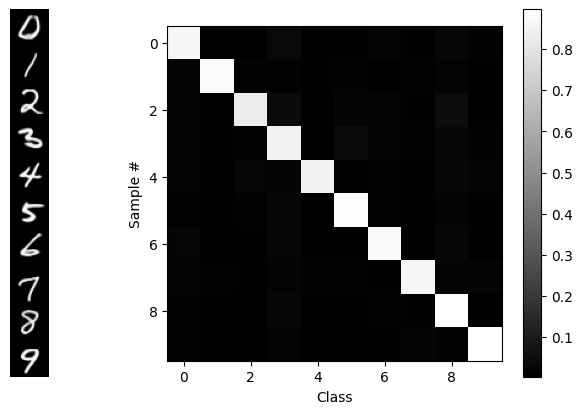

In [ ]:
torch.manual_seed(0) # for reproducibility as we change other things
with torch.no_grad():
   x1 = generate_samples(sub, n_samples=10, guidance_dict=guidance_dict, debug=False)
   logits, probs = classify(classifier, x1)
show_probs(probs, x=x1)

BLAM! Our desired goal: in order, along the diagonal. We see that guidance isn't perfect, but that's partially a function of the VAE and the flow model too.  

To get a better survey of the capabilities, let's make a 10x10 grid of outputs with classes along each column:

Integrating Path:   0%|          | 0/14 [00:00<?, ?it/s]

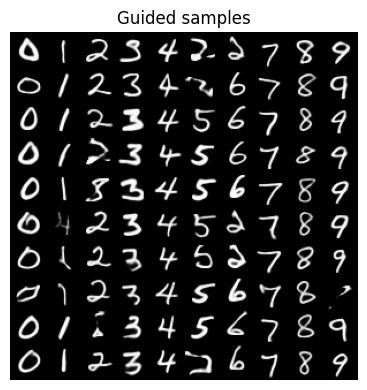

In [ ]:
target = torch.arange(10).repeat(10).to(device) #  [0,1,2,..9, 0,1,2,..9, ...]
guidance_dict['target'] = target
torch.manual_seed(42)         # (optional) for reproducibility
x1 = generate_samples(sub, n_samples=len(target), guidance_dict=guidance_dict)
show_grid(x1, "Guided samples")

That worked fine, and on a GPU it's pretty fast, but on a CPU, it's *painfully* slow. So instead, let's...

## Train a Latent Classifier
We'll train a model `z_classifier` that looks only in latent space, so we can use it as a guidance signal. This can be a very simple model consisting of a few `Linear` layers:

In [ ]:
class LatentClassNet(nn.Module):
    def __init__(self, latent_dim=16, hidden_dim=32, n_classes=10):
        super().__init__()
        dims = [latent_dim, hidden_dim, hidden_dim, latent_dim, n_classes]
        self.layers = nn.ModuleList([nn.Linear(in_d, out_d) for in_d, out_d in zip(dims[:-1], dims[1:])])   
    def forward(self, z):
        for layer in self.layers: z = F.leaky_relu(layer(z))
        return z

z_classifier = LatentClassNet().to(device)

It will operate on latent encodings of the MNIST dataset. So let's save the encoded latents to disk and load them into memory. These will be our training and test data. 

In [ ]:
#| code-fold: true

# You can probably skip this code block. It just runs MNIST
# through the VAE's encoder and saves it to disk. 

from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from glob import glob 
import math 

@torch.no_grad()
def encode_dataset(vae, dataset, batch_size=512, chunk_size=10000, tag="train"):
    """Encode dataset into VAE latents (z = mu), saving progress in temp chunk files.
    We use temp chunks in case execution gets interrupted, we can try again & resume. 
    """
    device = next(vae.parameters()).device
    total_chunks = math.ceil(len(dataset) / chunk_size) 
    # check for existing chunk files 
    basename = f"tmp_chunk_{tag}"
    chunk_files = glob(basename+'*.pt') 
    existing_chunks = len(chunk_files)
    print(f"{tag}: Found {existing_chunks} of {total_chunks} expected chunks. Generating remaining...")
    for c in range(existing_chunks, total_chunks): 
        print(f"chunk {c+1}/{total_chunks}:",end="")
        indices = list(range(c*chunk_size, (c+1)*chunk_size ))
        data_subset = Subset(dataset, indices)        
        loader = DataLoader(data_subset, batch_size=batch_size, shuffle=False)
        all_latents, all_labels = [], []
        must_flatten = None
        with torch.no_grad():
            for data, labels in loader:
                print("=",end="") # dumb progress bar 
                x = data.to(device)
                # next bit is so it should work with linear layers or conv
                if must_flatten is None or must_flatten==False:
                    try: z, must_flatten = vae.encoder(x), False
                    except RuntimeError:
                        z = vae.encoder(x.view(x.size(0), -1))
                        must_flatten = True
                else: z = vae.encoder(x.view(x.size(0), -1))
                mu, logvar = z
                all_latents.append(mu.cpu())
                all_labels.append(labels)
        chunk_latents, chunk_labels = torch.cat(all_latents), torch.cat(all_labels)
        tmp_filename = f"{basename}_{c+1}.pt"
        print(f"|  Saving chunk to {tmp_filename}")
        torch.save({ 'latents':chunk_latents, 'labels':chunk_labels }, tmp_filename)
    
    # Assemble all the chunks from files and return tensors.
    print("Assembling", basename+'*.pt ...')
    all_latents, all_labels = [], []
    for chunk_file in glob(basename+'*.pt'): 
        chunk_dict = torch.load(chunk_file, weights_only=True)
        all_latents.append(chunk_dict['latents'])
        all_labels.append(chunk_dict['labels']) 
    latents, labels = torch.cat(all_latents), torch.cat(all_labels)
    #for f in glob(tmp_file_base+'*.pt'): os.remove(f)   # clean up 
    return latents, labels 

def encode_mnist(vae, filename=None, batch_size=512):
    print("Acquiring train & test MNIST image datasets...")
    train_ds = MNIST(root='./data', train=True,  download=True, transform=ToTensor())
    test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
    
    print(f"\nEncoding dataset to latents...")
    train_latents, train_labels = encode_dataset(vae, train_ds, batch_size=batch_size, tag='train')
    test_latents, test_labels = encode_dataset(vae, test_ds, batch_size=batch_size, tag='test')
    for f in glob('tmp_chunk_t*_c*.pt'): os.remove(f)  # clean up

    if filename is not None:
        print(f"Saving to {filename} ...")
        torch.save({ 'train_z': train_latents,     'test_z': test_latents,
                     'train_labels': train_labels, 'test_labels': test_labels }, filename)
    return train_latents, train_labels


# Encode the dataset
latent_data_filename = 'mnist_latents.pt'
if not os.path.exists(latent_data_filename):
    train_latents, train_labels = encode_mnist(sub.vae, filename=latent_data_filename)




def load_data(filename):
    if 'MyDrive' in filename:
        from google.colab import drive
        drive.mount('/content/drive')
    data_dict = torch.load(filename, weights_only=True)
    return data_dict

data_dict = load_data(latent_data_filename)
train_z, test_z = data_dict['train_z'], data_dict['test_z']
train_z.shape, test_z.shape

# Create datasets from the latent tensors
train_latent_ds = TensorDataset(train_z, data_dict['train_labels'][:train_z.shape[0]])
test_latent_ds = TensorDataset(test_z, data_dict['test_labels'])

batch_size = 512
train_latent_dl = DataLoader(train_latent_ds, batch_size=batch_size, shuffle=True)
test_latent_dl = DataLoader(test_latent_ds, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_latent_dl)}, Test batches: {len(test_latent_dl)}")
# print single latent size
print(f"Latent size: {train_latent_ds[0][0].shape}")

Train batches: 118, Test batches: 20
Latent size: torch.Size([16])


Then we'll run the training loop...

<details>
<summary>Training Loop Code and Execution</summary>


In [ ]:
# Latent classifier training loop
optimizer  = torch.optim.Adam(z_classifier.parameters(), lr=1e-3, weight_decay=1e-5)
criterion  = nn.CrossEntropyLoss()
epochs = 8
for epoch in range(epochs):
    z_classifier.train()
    pbar = tqdm(train_latent_dl, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for latents, labels in pbar:
        optimizer.zero_grad()
        logits = z_classifier(latents.to(device))
        loss   = criterion(logits, labels.to(device))
        pbar.set_postfix({'train_loss': f"{loss.item():.4f}"})
        loss.backward()
        optimizer.step()
    
    # Validation
    z_classifier.eval()
    val_latents, val_labels = next(iter(test_latent_dl))
    val_logits = z_classifier(val_latents.to(device))
    val_loss   = criterion(val_logits, val_labels.to(device))
    val_acc    = (val_logits.cpu().argmax(dim=1) == val_labels).float().mean()
    print(f"Epoch {epoch+1}/{epochs}: train_loss={loss.item():.4f}, val_loss={val_loss.item():.4f}, val_acc={val_acc.item():.4f}")

Epoch 1/8:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 1/8: train_loss=0.9673, val_loss=1.1017, val_acc=0.6211


Epoch 2/8:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 2/8: train_loss=0.1901, val_loss=0.1919, val_acc=0.9375


Epoch 3/8:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 3/8: train_loss=0.0512, val_loss=0.1205, val_acc=0.9570


Epoch 4/8:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 4/8: train_loss=0.1193, val_loss=0.1022, val_acc=0.9668


Epoch 5/8:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 5/8: train_loss=0.0810, val_loss=0.0948, val_acc=0.9648


Epoch 6/8:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 6/8: train_loss=0.1569, val_loss=0.0815, val_acc=0.9707


Epoch 7/8:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 7/8: train_loss=0.0504, val_loss=0.0841, val_acc=0.9629


Epoch 8/8:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 8/8: train_loss=0.0408, val_loss=0.0792, val_acc=0.9746


</details>

Let's test our newly-trained latent classifier, to make sure it works before trying to use it for guidance.

**TODO:** clarify output

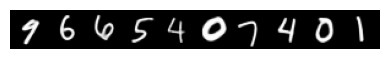

Target labels:    tensor([9, 6, 6, 5, 4, 0, 7, 4, 0, 1])
Predicted labels: tensor([9, 6, 6, 5, 4, 0, 7, 4, 0, 1])


In [ ]:
z, L = test_latent_ds[20:30]
z = z.to(device) 
show_grid(F.sigmoid(sub.decode(z)).view(-1,28,28))
with torch.no_grad():
    pred_class = classify(z_classifier, z, use_argmax=True)
print("Target labels:   ",L)
print("Predicted labels:", pred_class.cpu())

Looks pretty good.  Moving on to...

## Latents-Only Gudiance

Now that we have a trained classifier that operates in latent space, we can run basically the same code as before, only it will execute wayyyyy faster...

Integrating Path:   0%|          | 0/14 [00:00<?, ?it/s]

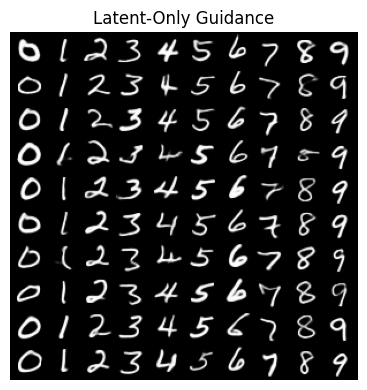

In [ ]:
#| code-fold: true
guidance_dict ={'classifier': z_classifier,
                'decode': None,    # no decoding, latent space only
                'loss_fn': torch.nn.CrossEntropyLoss(reduction='none'), # don't sum across batch dim
                'target': torch.arange(10).repeat(10).to(device),
                'strength': 5.0,   # "guidance strength"
                't_min': 0.01,  't_max': 0.99, }

torch.manual_seed(42) # remove for new samples each time
x1 = generate_samples(sub, n_samples=len(guidance_dict['target']), guidance_dict=guidance_dict)
show_grid(x1, "Latent-Only Guidance")

Was that fast or WHAT?!

Since we no longer have to propagate gradients through the much larger VAE decoder model and pixel-space classifer, we can get answers a lot faster via our small latents-only classifier.

Let's move on to another application of guidance, for which our guidance signal doesn't depend on a separate trained (classifier) model at all: inpainting.

# Inpainting

When inpainting, we have some "mask" inside which some of the data have been removed, and we want to use the model to fill in the missing part in a way that matches with the surrounding pixels. Let's take a look at an example from MNIST, where we show an original image, the mask and the masked-out image:

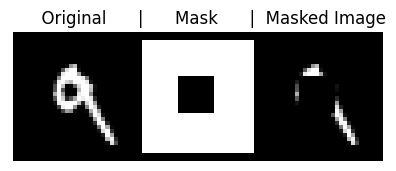

In [ ]:
#| code-fold: true

# Demo what inpainting looks like
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
x = test_ds[7][0]
H, W = x.shape[-2:]
M = torch.ones([H,W], dtype=x.dtype, device=x.device)   # 1 = keep pixels
M[H//3:2*H//3, W//3:2*W//3] = 0                         # 0 = mask out
x_masked = M*x
show_grid( torch.cat([x, M.unsqueeze(0), x_masked],dim=0),"      Original      |      Mask      |  Masked Image" )

Another example would be a picture of a face where you've blocked out the nose and you want the model to fill in a nose.

Now, some of the "filling in" you can get "for free" because the model has only been exposed to data that satisfies the manifold or probability distribution of the training data -- e.g. If it was trained on faces, then it only ever saw faces with noses and hence can only generate faces with noses -- but the real trick is to do it "well" and have it be "good" in the end. ;-)

There's a wealth of information on guidance as it was originally applied to diffusion models.
Sander Dieleman's blog post, ["Guidance: a cheat code for diffusion models"](https://sander.ai/2022/05/26/guidance.html)[@dieleman2022guidance], is a classic and should (eventually) be read by all.  Yet because of the stochastic/random nature of the diffusion path, there are several "complicating" aspects of diffusion guidance that we're going to gloss over in this tutorial because in the case of deterministic, smooth flow-model trajectories, things become a lot more intuitive.

We'll follow a method outlined in the paper ["Training-free Linear Image Inverses via Flows"](https://arxiv.org/abs/2310.04432)[@pokle2024trainingfree] by Pokle et al, a methoda that applies to general linear inverse problems of which inpainting is a particular case, and we'll simplify their method to adapt it for *just inpainting.*

The method will be to try to generate an *entire* new image $x_1$ that everywhere *outside the mask matches up* with the pixels in user-supplied (masked) image $y$.  So the constraint will be, given a 2D mask $M$ (where $M$=1 means there's an original pixel there, and $M$=0 is the masked-out region), to require that our estimate image $\widehat{x_1}$ (i.e. the decoded image version of the estimated latets $\widehat{z_1}$   ) satisfies  $M*\widehat{x_1} = M* y$, or in a "residual form", we'll just compute the Mean Squared Error (MSE) of $M*(\widehat{x_1}-y)$:

$$ {\rm Constraint:} = M^2 * (\widehat{x_1}-y)^2 $$
(and if we want, we can use the fact that $M$ being a binary mask means $M^2 = M$).

If we want to do latent-only inpainting (which will be the fastest), then the same constraint applies just with the simplification $\widehat{x_1} = \widehat{z_1}$

The authors of the paper recommend only doing guidance from $t=0.2$ onward because prior to that, it's hard to make any meaningful estimate.. In fact, they don't even integrate before $t = 0.2$. They just interpolate between the source and the target data to get their starting point at  $t = 0.2$.

To use our constraint in the guidance equation (3) for computing $\Delta v\,$, we'll need to turn our constraint into a likelihood by raising it to an expontential power -- so we get a Gaussian! But the guidance equation includes a logarithm that immediately *undoes* our exponentiation:

$$ \Delta v = - {\eta \over 1-t} \nabla_{z_t} \ \,{\color{red}{\text{l̸o̸g̸}\,\text{e̸x̸p̸}}}
\left(  M^2 * (\widehat{x_1}-y)^2 \right) .$$

The gradient part is
 $$ \nabla_{z_t} M^2 *(\widehat{x_1}-y)^2 = 2M^2*(\widehat{x_1}-y) {\partial \widehat{x_1} \over \partial z_t } $$

If we're inpainting in latent space and not using the decoder for the constraint, then ${\partial \widehat{x_1} / \partial z_t } = 1$.  Otherwise that term will require evaluation via PyTorch's `autograd` (=slow).

Our earlier time scaling was $1/(1-t)$; turns out that doesn't work very well in practice when it comes to inpainting. Instead, we'll use a different time scaling that delivers good (albeit not perfect) results:  $(1-t)/t$.  Thus our full equation for the velocity correction will be:

$$ \Delta \vec{v} = -\eta {1-t\over t} M^2 *(\widehat{x_1} - y){\partial\widehat{x_1}\over\partial{z_t}},  $$
where we absorbed the factor of 2 into  $\eta$, and the last partial derivitive term can be one if we do latent-only inpainting.

Let's implement this in code, using two different versions of the gradient calculation, depending on whether we can do it all in latent space or if we need to propagate gradients through the decoder:

In [ ]:
#| code-fold: true

@torch.no_grad()  # gradients computed analytically!
def ip_latents_grad(v_t, z, t, g:dict, eps=1e-6, **kwargs):
    "inpainting gradients for latent-only guidance, fast"
    z1_hat = z + (1-t)*v_t
    return g['M_sq'] * (z1_hat - g['y'])  #  x1_hat = z1_hat, dz1_hat/dz_t=1


@torch.enable_grad()
def ip_pixels_grad(v_t, z, t, g:dict, eps=1e-6, **kwargs):
    "inpainting gradients for pixel-space guidance. needs decoder & tracks via autograd, = slow"
    z.requires_grad_(True)
    z1_hat = z + (1-t)*v_t
    x1_hat = F.sigmoid(g['decode'](z1_hat)).view(-1,1,28,28) # TODO: un-hard-code img size
    grad_x = g['M_sq'] * (x1_hat - g['y'])
    grad_z = torch.autograd.grad(x1_hat, z, grad_outputs=grad_x,retain_graph=False)[0] # mults grad_x by dx1_hat/dz1_hat
    z.requires_grad_(False)
    return grad_z.detach()  # don't send gradients onward


def t_timescale(t, timescale='mine', **kwargs):
    "our choice for adaptive time sacle"
    if timescale =='simple': return 1/(1-t)       # our earlier scale; doesn't work
    elif timescale=='pokle': 
        return (1-t)**2 / ((1-t)**2 + t**2)  # from pokle et al; can't get it to work
    elif timescale=='constant': return 4     # or any constant. The 4 is from Pokle et al
    else: return (1-t)/t  # Works pretty well! Strong guidance at start, zero at end


def compute_dv_inpainting(v_t, z, t, g:dict, **kwargs):
    "wrapper to call appropriate gradient-computation routine"
    if t < g['t_min'] or t > g['t_max']: return torch.zeros_like(v_t)
    grad_fn = ip_latents_grad if g['decode'] is None else ip_pixels_grad
    grad = grad_fn(v_t, z, t, g, **kwargs)
    dv = -g['strength'] * t_timescale(t, **kwargs) * grad
    return dv.detach()

## Do the Inpainting

Start with masked images $y$...

torch.Size([50, 1, 28, 28])


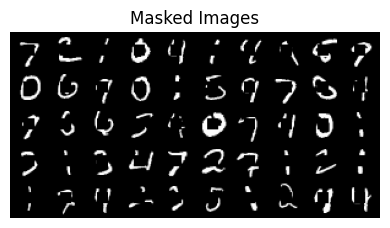

In [ ]:
#| code-fold: true

# setup the data
y = torch.stack([test_ds[i][0] for i in range(50)])
print(y.shape)
y = M*y
show_grid(y.squeeze(), "Masked Images")

And now we run the inpainting code

Integrating Path:   0%|          | 0/14 [00:00<?, ?it/s]

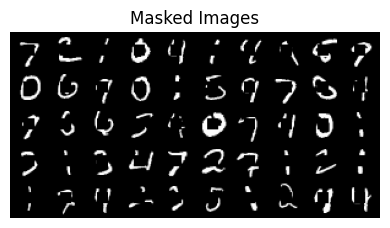

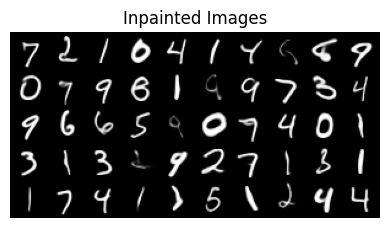

In [ ]:
#| code-fold: true

compute_dv = compute_dv_inpainting  # register our new guidance routine

inpainting_dict ={'decode': sub.decode,         # how to decode to pixel space for classifier
                'M_sq': (M**2).to(device),
                'y': y.to(device),
                'strength': 1.0,              # "guidance strength", you may vary this
                't_min': 0.2, 't_max': 0.999} # t range to apply guidance, may vary these

with torch.no_grad():
    torch.manual_seed(0) # for reproducibility as we change other things
    t0 = 0.2             # starting time as per Pokle et al
    z0 = torch.randn([len(y), sub.latent_dim]).to(sub.device)
    zy = sub.encode(y.to(device))   # encoded version of masked image
    z0 = z0 * (1-t0) + zy * t0      # interpolation init
    inpainting_dict['t_min'] = t0
    x1 = generate_samples(sub, n_samples=len(y), t0=t0, z0=z0, guidance_dict=inpainting_dict, warp_fn=None, debug=False)

show_grid(y.squeeze(), "Masked Images")
show_grid(x1, "Inpainted Images") 

We see that the generated images generally look great, although in some cases, the in-painting code has changed pixels even where the mask is 1. We can disallow this by just resetting those values to the pixels in $y$.

Turning up the guidance strength would also enforce our constraint better, but turning up too high causes the whole thing to diverge and we get garbage out.

In order to experiment with other methods more easily, we should do inpainting only in latent space, and for that we will need a model that supports spatial latents....

## Latent-Only Inpainting

In [ ]:
#| include: false

# Get Spatial VAE & FLow Dit Model
!wget -q --no-clobber=off https://raw.githubusercontent.com/dlaieburner/2025-leaderboard/refs/heads/main/sample_submission_dit.py

try:
    del SubmissionInterface # remove Marco's from earlier; make it reload
except NameError:
    pass  # nevermind

from sample_submission_dit import SubmissionInterface

sub = SubmissionInterface().to(device)

device = mps


Downloading...
From: https://drive.google.com/uc?id=1kPK3ZPadOUEfH8ZycrG3k27pl9-lGUeL
To: /Users/shawley/github/blog/posts/downloaded_vae.safetensors
100%|████████████████████████████████████████████████████████████████████████████████| 12.6M/12.6M [00:00<00:00, 13.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1q9Iguf--2_MqUjsosS7iAGGzYtVfJ3UF
To: /Users/shawley/github/blog/posts/downloaded_flow.safetensors
100%|████████████████████████████████████████████████████████████████████████████████| 34.1M/34.1M [00:02<00:00, 16.7MB/s]


  0%|          | 0.00/12.6M [00:00<?, ?B/s]

  4%|▍         | 524k/12.6M [00:00<00:02, 4.41MB/s]

 25%|██▌       | 3.15M/12.6M [00:00<00:00, 16.1MB/s]

 46%|████▌     | 5.77M/12.6M [00:00<00:00, 18.5MB/s]

 79%|███████▉  | 9.96M/12.6M [00:00<00:00, 26.8MB/s]

100%|██████████| 12.6M/12.6M [00:00<00:00, 24.0MB/s]

Downloading...
From: https://drive.google.com/uc?id=1q9Iguf--2_MqUjsosS7iAGGzYtVfJ3UF
To: /Users/shawley/github/blog/posts/downloaded_flow.safetensors


  0%|          | 0.00/34.1M [00:00<?, ?B/s]

  2%|▏         | 524k/34.1M [00:00<00:08, 4.17MB/s]

 11%|█         | 3.67M/34.1M [00:00<00:01, 17.3MB/s]

 22%|██▏       | 7.34M/34.1M [00:00<00:01, 24.7MB/s]

 29%|██▉       | 9.96M/34.1M [00:00<00:01, 23.2MB/s]

 42%|████▏     | 14.2M/34.1M [00:00<00:00, 29.2MB/s]

 52%|█████▏    | 17.8M/34.1M [00:00<00:00, 30.8MB/s]

 63%|██████▎   | 21.5M/34.1M [00:00<00:00, 31.3MB/s]

 74%|███████▍  | 25.2M/34.1M [00:00<00:00, 30.3MB/s]

 85%|████████▍ | 28.8M/34.1M [00:01<00:00, 31.0MB/s]

 95%|█████████▌| 32.5M/34.1M [00:01<00:00, 32.1MB/s]

100%|██████████| 34.1M/34.1M [00:01<00:00, 28.7MB/s]

Let's take a look at the images and their spatial-latent representations:

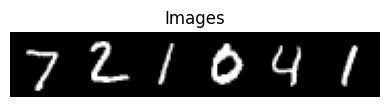

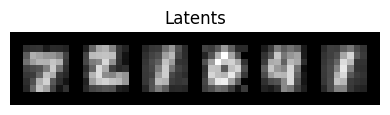

In [ ]:
#| code-fold: true

# viz images and spatial latents
from torchvision.datasets import MNIST
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())

x = torch.stack([test_ds[i][0] for i in range(6)])
if len(x.shape) < 4: x1 = x.unsqueeze(1)
show_grid(x, "Images")
z1 = sub.encode(x)
show_grid((z1-z1.min())/(z1.max()-z1.min()), "Latents")

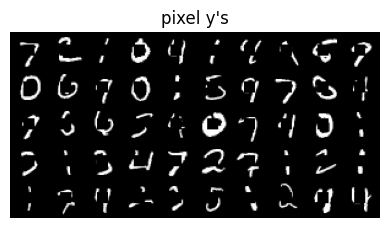

Integrating Path:   0%|          | 0/14 [00:00<?, ?it/s]

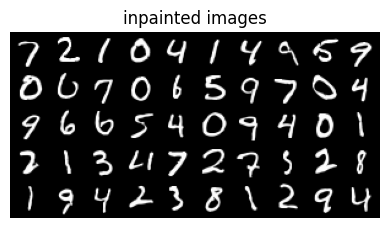

In [ ]:
def prepare_latent_mask(image, mask, encoder):
    z_y = encoder(image.to(device))
    M_z = F.interpolate(mask[None, None], size=z_y.shape[-2:], mode='bilinear', align_corners=False).to(device)
    M_z = (M_z > 0.9).float()    # binarize it
    return z_y * M_z, M_z**2


@torch.no_grad()
def latents_only_inpaint(sub, inpainting_dict, n_samples, n_steps=20, t0=0.2, warp_fn=None):
    z_y, M_sq = prepare_latent_mask(y, M, sub.encode)   
    inpainting_dict.update({'M_sq': M_sq, 'y': z_y, 't_min': t0})
    z0 = torch.randn_like(z_y) * (1-t0) + z_y * t0         # Initialize via interpolation
    return generate_samples(sub, n_samples, t0=t0, z0=z0,  guidance_dict=inpainting_dict, warp_fn=warp_fn)


inpainting_dict ={'decode': None,            # now we're latents-only
                'strength': 1.0,             # "guidance strength", you may vary this
                't_min': 0.2, 't_max': 0.999} # t range to apply guidance, may vary these

show_grid(y.squeeze(), "pixel y's")
x1 = latents_only_inpaint(sub, inpainting_dict, n_samples=len(y), n_steps=10)
print()
show_grid(x1, "inpainted images")

# PnP-Flow: Guidance By Another Name

The term 'guidance' typically refers to velocity modifications, but PnP-Flow by Martin et al[@pnp_flow] achieves similar results by adjusting latent positions $z$ directly.[^1][^2]

PnP-Flow assumes straight-line trajectories, making the forward projection trivial: $\widehat{z_1}$
is reached by simple linear extrapolation.  Instead of incrementally moving $z$ from $t=0$ to $t=1$, PnP-Flow projects forward to $\widehat{z_1}$ and iterates on that estimate through a series of correction and projection steps. The first step applies our gradient correction:

$${\rm Step\ 1.}\ \ \ \ \ \  \ \ \ \ \ \ z_1^* := \widehat{z_1} - \eta\,\gamma_t \nabla F(\widehat{z_1},y)$$

where $z_1^*$ (my notation) is our goal i.e. the the endpoint of our projected course correction, and $F(\widehat{z_1},y)$ is our (log-exp probability) constraint.  For the time scaling, the PnP-Flow authors recommend $\gamma_t = (1-t)^\alpha$
with $\alpha \in [0,1]$ is a hyperparameter chosen according to the task -- e.g., they use $\alpha$'s as large as 0.8 for denoising tasks, 0.5 for box inpainting, and 0.01 for random inpainting. This choice of $\gamma_t$ is a bit different from our earlier one of $(1-t)/t$. Both go to zero as $t \rightarrow 1$, but approach it differently and have different asymtomptotics as $t\rightarrow 0$.

In the graph below, we show our earlier choice of $(1 - t)/t$ in green and $(1 - t)^\alpha$ in purple for various choices of $\alpha$:

In [ ]:
#| echo: false
HTML('''
<iframe src="https://www.desmos.com/calculator/bcp2wiyyid?embed"
width="220" height="300" style="border: 1px solid #ccc; display: block; margin: 0 auto;" frameborder=0></iframe>''')

...where for "box inpainting" as we did above, they use $\alpha$=0.5.

But PnP-Flow doesn't stop there!  Two other key steps remain. We then project backward to *overwrite* $z_t$ with a corrected value:

$${\rm Step\ 2.}\ \ \ \ \ \  \ \ \ \  \ \ z_t := (1-t)\,z_0 + t\, z_1^* $$

We then compute a new projected estimate, same as we have before:

$${\rm Step\  3.}\ \ \ \ \ \   \widehat{z_1} := z_t + (1-t)\,v_t(z,t)$$

....and loop over Steps 1 to 3 for each value of $t$ in our set of (discrete) integration steps, i.e. after Step 3, we let $t := t+\Delta\,t$ and go back to Step 1. Our final value of $\widehat{z_1}$ will be the output.

This image from the PnP-Flow paper may prove instructive, showing 3 different instances of the 3 PNP steps:

<style>
.img3 {
    /*transform-origin: top left;*/
    /*width:140px;*/
    transition:transform 0.4s ease;
    position: relative;
    z-index: 0;
}
.img3:hover {
    -webkit-transform:scale(1.35);
    transform:scale(1.35);
    z-index:1;
}
</style>

![Image from PnP-Flow paper \[5\], slightly re-annotated by me.](images/pnp_flow_diag_mod.png){.img3}

This has a superficial resemblance to the "[ping pong](https://github.com/Stability-AI/stable-audio-tools/blob/31932349d98c550c48711e7a5a40b24aa3d7c509/stable_audio_tools/inference/sampling.py#L221)" integration method used by Stable Audio Open Small (SAOS) [@sao_small], with a key distinction: SAOS maintains and updates the time-integrated latent variable $z$ (called "$x$" in SAOS), whereas for PnP-Flow it is the projection $\widehat{z_1}$ (called ["denoised"](https://github.com/Stability-AI/stable-audio-tools/blob/31932349d98c550c48711e7a5a40b24aa3d7c509/stable_audio_tools/inference/sampling.py#L242)) in SAOS) that is the primary variable that is maintained between steps. This is a subtle distinction but worth noting.[^3]

[^3]: In keeping with the "Zack Novack" theme: the trivial nature of integration for near-OT paths of flow models means that one can implement a flow version of DITTO [@ditto] that avoids the expensive back-integration needed for diffusion models. The result is also superficially similar to PnP-Flow, but with gradients computed with respect to $z$ instead of $\widehat{z_1}$. 


To implement PnP-Flow in code, let's replace our "integrator" with something specific to PnP-Flow:

In [ ]:
@torch.no_grad()
def sample_pnpflow(model, z0, n_steps=10, alpha=0.5, n_avg=5, warp_fn=lambda x: x, guidance_dict=None):
    ts = warp_fn(torch.linspace(0, 1, n_steps, device=z0.device, dtype=z0.dtype))  
    z1_hat = z0
    for t in ts[1:]:
        grad = guidance_dict['M_sq'] * (z1_hat - guidance_dict['y'])
        gamma_t = (1 - t) ** alpha
        z1_star = z1_hat - guidance_dict['strength'] * gamma_t * grad        
        projections = []           # Average multiple noisy projections
        for _ in range(n_avg):
            z = t * z1_star  +  (1 - t) * torch.randn_like(z1_star) 
            projections.append(z + (1 - t) * model(z, t))
        z1_hat = torch.stack(projections).mean(dim=0)
    return z1_hat

The model we used earlier for latents-only inpainting was trained to have straight trajectories, so we should be able to use it again here, just calling `sample_pnpflow` (instead of `integrate_path`). The results are as follows:

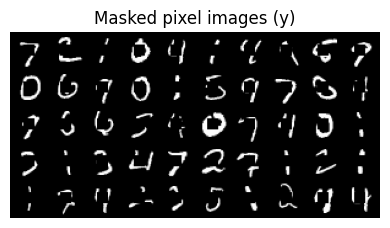

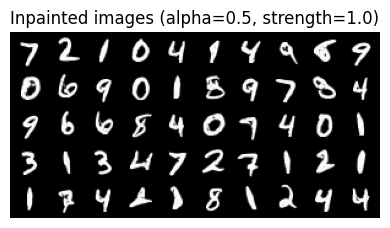

In [ ]:
#| code-fold: true
@torch.no_grad()
def pnp_flow_inpaint(sub, inpainting_dict, n_samples, n_steps=10, t0=0, seed=None, **kwargs):
    """Inpaint using PnP-Flow method"""
    if seed is not None: torch.manual_seed(seed)
    z_y, M_sq = prepare_latent_mask(y, M, sub.encode)
    inpainting_dict.update({'M_sq': M_sq, 'y': z_y, 't_min': t0})
    z0 = torch.randn_like(z_y) * (1-t0) + z_y * t0
    return sample_pnpflow(sub.flow_model, z0, guidance_dict=inpainting_dict, **kwargs)


inpainting_dict = {'strength': 1.0, 't_min': 0.0, 't_max': 0.999}

show_grid(y,"Masked pixel images (y)")

z1 = pnp_flow_inpaint(sub, inpainting_dict, n_samples=len(y), n_steps=20, alpha=0.5, seed=0)
x1 = F.sigmoid(sub.decode(z1)).cpu()   # convert latents to pixels
show_grid(x1, f"Inpainted images (alpha=0.5, strength={inpainting_dict['strength']})")

...So this *kind of* works, but it also seems to "take some liberties" -- the new digits look like "bold" versions of the originls.  This could be because of the low spatial resolution of the latents, e.g. that they are encoding information about curvature.

# Summary

**TODO:**

# Acknowledgements 
This work was supported by Hyperstate Music, Inc. who are awesome and you should invest in them. ;-)  For providing feedback on early drafts of this tutorial: thanks to Raymond Fan, Alan Lockett, and my amazing students in PHY/DSC/BSA 4420, "Deep Learning and AI Ethics"!  Also thanks to Danilo Comminiello and the signal processing at Sapienza University of Rome for encouraging me to present a preceding lecture at IJCNN 2025 -- this blog post is the missing piece! 

This document was partially prepared using the [SolveIt](https://solve.it.com/) platform of Answer.ai and via many discussions with Claude.ai; still overwhelmingly authored by the hands of here human.

# References

::: {#refs}
:::

# MORE References

TODO: actually cite these

5. Lipman et al 
6. Ye et al, "TFG: Unified Training-Free Guidance for Diffusion Models," NeurIPS 2024, [arXiv:2409.15761](https://arxiv.org/abs/2409.15761), [GitHub](https://github.com/YWolfeee/Training-Free-Guidance)
7. Daras et al, "A Survey on Diffusion Models for Inverse Problems", https://arxiv.org/abs/2410.00083v1
8. Blasingame & Liu, "Greed is Good: A Unifying Perspective on Guided Generation," https://arxiv.org/abs/2502.08006
10. paper on steering autoregressive models


[^1]: The paper by Pokle et al we cited earlier also included a related method, however the PnP-Flow method is a bit more general and *much* more readable than Pokle et al. ;-) Plus, Anne Gagneux provided [code](https://github.com/annegnx/PnP-Flow) for PnP-Flow!  Gangeux's repo even provides code for the position-only (non-velocity) algorithm from Pokle et al aka "OT-ODE".


[^2]: Differences between our variables and those in the PnP-Flow paper: For us, $z$ are integrated flow latent variables between $z_0$ (source) and $z_1$ (target), whereas $x$ are the pixel-space representations via our VAE's decoder $\mathscr{D}$ such that $\mathscr{D}(z)=x$. In PnP-Flow, $x$ is the integrated flow  variable, $z$ is used only for their interpolation/overwrite step, and $\mathscr{D}$ is the "denoiser" aka their flow model.
